# Part 2 : Data Ingestion


## 1. Data fetching


In [1]:
!pip install understatapi

In [2]:
league_name = ["EPL", "La_Liga", "Bundesliga", "Serie_A", "Ligue_1", "RFPL"]

In [3]:
league_data = {}
team_data = []
player_data = []
match_data = []
shot_data = []

In [4]:
from understatapi import UnderstatClient

understat = UnderstatClient()

### create index for each league


In [5]:
import uuid

# league_name_to_id
league_name_to_id = {league_name: str(uuid.uuid4()) for league_name in league_name}

league_data = {
    league_name_to_id[league]: {
        "_id": league_name_to_id[league],
        "name": league,
        "season": "2024",
    }
    for league in league_name
}

league_data

{'9fd25e60-41da-448d-a578-c2cfd8bd7111': {'_id': '9fd25e60-41da-448d-a578-c2cfd8bd7111',
  'name': 'EPL',
  'season': '2024'},
 'f1d3d848-0781-46b2-bf50-c2718539c5f5': {'_id': 'f1d3d848-0781-46b2-bf50-c2718539c5f5',
  'name': 'La_Liga',
  'season': '2024'},
 '9f469b09-23ae-4d66-b9e5-cb1f20e50b9a': {'_id': '9f469b09-23ae-4d66-b9e5-cb1f20e50b9a',
  'name': 'Bundesliga',
  'season': '2024'},
 '812bdb81-99fb-4157-8b8d-21a6cfd8cbb7': {'_id': '812bdb81-99fb-4157-8b8d-21a6cfd8cbb7',
  'name': 'Serie_A',
  'season': '2024'},
 '7483f73f-bb5d-403c-9023-6a7a756200a8': {'_id': '7483f73f-bb5d-403c-9023-6a7a756200a8',
  'name': 'Ligue_1',
  'season': '2024'},
 '104fddf8-6a47-4724-b696-a9c48e401664': {'_id': '104fddf8-6a47-4724-b696-a9c48e401664',
  'name': 'RFPL',
  'season': '2024'}}

In [6]:
def prepare_data(league, season):
    league_team_data = understat.league(league).get_team_data(season)
    league_player_data = understat.league(league).get_player_data(season)
    league_match_data = understat.league(league).get_match_data(season)

    #### league_data
    league_data[league_name_to_id[league]]["team_count"] = len(league_team_data)
    league_data[league_name_to_id[league]]["player_count"] = len(league_player_data)
    league_data[league_name_to_id[league]]["match_count"] = len(league_match_data)
    sorted_match_data = sorted(league_match_data, key=lambda x: x["datetime"])

    start_date = sorted_match_data[0]["datetime"]
    end_date = sorted_match_data[-1]["datetime"]

    league_data[league_name_to_id[league]]["start_date"] = start_date
    league_data[league_name_to_id[league]]["end_date"] = end_date

    print("-    League data prepared")

    # Team data & Player data
    for team_key, team_info in league_team_data.items():
        team_title = team_info["title"]
        team_extract = {
            "_id": team_info["id"],
            "title": team_info["title"],
            "league_id": league_name_to_id[league],
        }

        # player data
        team_players = understat.team(team_title).get_player_data(season)

        team_extract["player_list"] = [player["id"] for player in team_players]

        team_data.append(team_extract)

        player_data.extend(
            {
                "_id": player["id"],
                "name": player["player_name"],
                "goals": int(player["goals"]),
                "assists": int(player["assists"]),
                "team": team_info["title"],
                "position": player["position"],
                "league_id": league_name_to_id[league],
            }
            for player in team_players
        )

    print("-    Team data prepared")
    print("-    Player data prepared")

    #### match_data

    # Populating match_data from league_match_data
    match_extract = [
        {
            "_id": match["id"],
            "home_team_id": match["h"]["id"],
            "home_team_title": match["h"]["title"],
            "away_team_id": match["a"]["id"],
            "away_team_title": match["a"]["title"],
            "home_team_goals": int(match["goals"]["h"]) if match["goals"]["h"] else 0,
            "away_team_goals": int(match["goals"]["a"]) if match["goals"]["a"] else 0,
            "datetime": match["datetime"],
            "league_id": league_name_to_id[league],
        }
        for match in league_match_data
    ]

    match_data.extend(match_extract)

    print("-    Match data prepared")

    ### shot data

    def get_shot_data(match_id):
        try:
            data = understat.match(match_id).get_shot_data()
            return data
        except Exception as e:
            print(f"Error fetching shot data for match {match_id}: {e}")
            return None

    shot_extract = []
    for match in match_extract[:15]:
        raw_shot_data = get_shot_data(match["_id"])
        if raw_shot_data:
            raw_shot_data = raw_shot_data["h"] + raw_shot_data["a"]
            shot_extract.extend(
                {
                    "_id": shot["id"],
                    "match_id": shot["match_id"],
                    "player_id": shot["player_id"],
                    "minute": int(shot["minute"]),
                    "result": shot["result"],
                    "coordinates": [float(shot["X"]), float(shot["Y"])],
                    "short_type": shot["shotType"],
                    "h_a": shot["h_a"],
                    "situation": shot["situation"],
                    "h_team": shot["h_team"],
                    "a_team": shot["a_team"],
                    "h_goals": int(shot["h_goals"]),
                    "a_goals": int(shot["a_goals"]),
                    "date": shot["date"],
                    "player_assisted": shot["player_assisted"],
                    "player": shot["player"],
                }
                for shot in raw_shot_data
            )

    shot_data.extend(shot_extract)

    print("-    Shot data prepared")

### Making requests to Understat API to prepare data 2 times

#### The first time is to prepare data for the first 3 leagues


In [7]:
# Prepare data for the first 3 leagues
for league in league_name[:3]:
    print(f"Preparing data for {league}:")
    prepare_data(league, "2024")
    print("")

Preparing data for EPL:
-    League data prepared
-    Team data prepared
-    Player data prepared
-    Match data prepared
-    Shot data prepared

Preparing data for La_Liga:
-    League data prepared
-    Team data prepared
-    Player data prepared
-    Match data prepared
-    Shot data prepared

Preparing data for Bundesliga:
-    League data prepared
-    Team data prepared
-    Player data prepared
-    Match data prepared
-    Shot data prepared



#### The second time is to prepare data for the latter half of leagues


In [8]:
for league in league_name[3:]:
    print(f"Preparing data for {league}:")
    prepare_data(league, "2024")
    print("")

Preparing data for Serie_A:
-    League data prepared
-    Team data prepared
-    Player data prepared
-    Match data prepared
-    Shot data prepared

Preparing data for Ligue_1:
-    League data prepared
-    Team data prepared
-    Player data prepared
-    Match data prepared
-    Shot data prepared

Preparing data for RFPL:
-    League data prepared
-    Team data prepared
-    Player data prepared
-    Match data prepared
-    Shot data prepared



#### checking the length of the data


In [9]:
print("league_data", len(league_data))
print("team_data", len(team_data))
print("player_data", len(player_data))
print("match_data", len(match_data))
print("shot_data", len(shot_data))

league_data 6
team_data 112
player_data 2774
match_data 1992
shot_data 2265


## 2. Populate to mongodb


In [10]:
!pip install pymongo

### Connect to MongoDB


In [11]:
from pymongo import MongoClient, ASCENDING, DESCENDING
from pymongo.errors import DuplicateKeyError, CollectionInvalid
from pprint import pprint
import datetime

# MongoDB connection
client = MongoClient("mongodb://localhost:27017/")  # Update URI if needed
db = client["sportDB"]  # Database name

# check if the database exists and connected
print(client.list_database_names())

['admin', 'chat', 'config', 'local']


#### Create Index for fast queries later


In [12]:
### LEAGUES COLLECTION
leagues_collection = db["leagues"]

# Unique index on _id is created by default
# Index on 'name'
leagues_collection.create_index([("name", ASCENDING)], name="name_idx")

# ------------------------------
### TEAMS COLLECTION
teams_collection = db["teams"]

# Unique index on _id is created by default
# Index on 'league_id'
teams_collection.create_index([("league_id", ASCENDING)], name="league_id_idx")

# Index on 'title'
teams_collection.create_index([("title", ASCENDING)], name="title_idx")

# ------------------------------
### PLAYERS COLLECTION
players_collection = db["players"]

# Unique index on _id is created by default
# Index on 'league_id'
players_collection.create_index([("league_id", ASCENDING)], name="league_id_idx")

# Index on 'name'
players_collection.create_index([("name", ASCENDING)], name="name_idx")

# ------------------------------
matches_collection = db["matches"]

# Unique index on _id is created by default
# Index on 'league_id'
matches_collection.create_index([("league_id", ASCENDING)], name="league_id_idx")

# Index on 'home_team_id'
matches_collection.create_index([("home_team_id", ASCENDING)], name="home_team_id_idx")

# Index on 'away_team_id'
matches_collection.create_index([("away_team_id", ASCENDING)], name="away_team_id_idx")

# Index on 'datetime'
matches_collection.create_index([("datetime", ASCENDING)], name="datetime_idx")

# ------------------------------
shots_collection = db["shots"]

# Unique index on _id is created by default
# Index on 'match_id'
shots_collection.create_index([("match_id", ASCENDING)], name="match_id_idx")

# Index on 'player_id'
shots_collection.create_index([("player_id", ASCENDING)], name="player_id_idx")

# Index on 'minute'
shots_collection.create_index([("minute", ASCENDING)], name="minute_idx")

# Index on 'result'
shots_collection.create_index([("result", ASCENDING)], name="result_idx")

# Index on 'shot_type'
shots_collection.create_index([("shot_type", ASCENDING)], name="shot_type_idx")

# Additional Indexes for Updated Fields
shots_collection.create_index([("situation", ASCENDING)], name="situation_idx")
shots_collection.create_index([("h_team", ASCENDING)], name="h_team_idx")
shots_collection.create_index([("a_team", ASCENDING)], name="a_team_idx")
shots_collection.create_index([("h_goals", ASCENDING)], name="h_goals_idx")
shots_collection.create_index([("a_goals", ASCENDING)], name="a_goals_idx")
shots_collection.create_index(
    [("player_assisted", ASCENDING)], name="player_assisted_idx"
)

# Composite Index: Querying shots by player and match
shots_collection.create_index(
    [("player_id", ASCENDING), ("match_id", ASCENDING)], name="player_match_idx"
)

# ------------------------------
### LIVE COMMENTARY COLLECTION
live_commentary_collection = db["liveCommentary"]

# Index on 'match_id' for quick match-based queries
live_commentary_collection.create_index([("match_id", ASCENDING)], name="match_id_idx")

# Index on 'timestamp' for sorting and range queries
live_commentary_collection.create_index(
    [("timestamp", ASCENDING)], name="timestamp_idx"
)

# Index on 'event' for filtering by event type
live_commentary_collection.create_index([("event", ASCENDING)], name="event_idx")

# Index on 'match_id' for match-specific queries
live_commentary_collection.create_index([("match_id", ASCENDING)], name="match_id_idx")

# Composite Index on 'match_id' and 'timestamp' for ordered retrieval
live_commentary_collection.create_index(
    [("match_id", ASCENDING), ("timestamp", ASCENDING)], name="match_timestamp_idx"
)

'match_timestamp_idx'

#### Populate data into MongoDB

#### use upsert to ensure all data are inserted once only


In [13]:
# Convert league_data dictionary to a list of dictionaries
league_data_list = list(league_data.values())

from pymongo import UpdateOne


def upsert_documents(collection, data):
    """Upserts documents into a collection."""
    # Create a list of upsert operations
    operations = [
        UpdateOne(
            {"_id": item["_id"]},  # Match condition (find document by _id)
            {"$setOnInsert": item},  # Insert only if not found
            upsert=True,
        )
        for item in data
    ]

    # Perform bulk upsert
    if operations:
        result = collection.bulk_write(operations)
        print(
            f"{collection.name}: Matched: {result.matched_count}, Inserted: {result.upserted_count}"
        )
    else:
        print(f"No data to upsert for {collection.name}.")


# Perform upsert for each collection
upsert_documents(leagues_collection, league_data_list)
upsert_documents(teams_collection, team_data)
upsert_documents(players_collection, player_data)
upsert_documents(matches_collection, match_data)
upsert_documents(shots_collection, shot_data)

leagues: Matched: 0, Inserted: 6
teams: Matched: 0, Inserted: 112
players: Matched: 33, Inserted: 2741
matches: Matched: 0, Inserted: 1992
shots: Matched: 0, Inserted: 2265


# Data Consistency Check


### 1. Check if player plays for valid team in a league


In [14]:
# Import required libraries
from pymongo import MongoClient
import pandas as pd
from collections import defaultdict

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["sportDB"]

# Access the Players and Teams collections
players_collection = db["players"]
teams_collection = db["teams"]

# Fetch all teams
teams = list(teams_collection.find())

# Build a mapping from team_title to player_ids
team_title_to_player_ids = {}
for team in teams:
    team_title = team.get("title")
    player_list = team.get("player_list", [])
    team_title_to_player_ids[team_title] = player_list

# Fetch all players
players = list(players_collection.find())

# Build mappings:
# player_id_to_team_title: player_id -> team_title (from Players collection)
# player_id_to_name: player_id -> player_name
player_id_to_team_title = {}
player_id_to_name = {}
for player in players:
    player_id = player.get("_id")
    player_name = player.get("name", "Unknown")
    team_title = player.get("team", None)
    player_id_to_team_title[player_id] = team_title
    player_id_to_name[player_id] = player_name

# Build reverse mapping: player_id -> list of team_titles from Teams collection
player_id_to_teams_in_player_list = defaultdict(list)

for team_title, player_ids in team_title_to_player_ids.items():
    for pid in player_ids:
        player_id_to_teams_in_player_list[pid].append(team_title)

# List to hold problematic players
problematic_players_forward = []

# Set of all valid team titles for quick lookup
valid_team_titles = set(team_title_to_player_ids.keys())

# Forward Validation
for player in players:
    pid = player.get("_id")
    pname = player.get("name", "Unknown")
    player_team_title = player.get("team", None)

    # 1. Existence Check: Does the team exist?
    if player_team_title not in valid_team_titles:
        problematic_players_forward.append(
            {
                "Player ID": pid,
                "Player Name": pname,
                "Player Team (Players Collection)": player_team_title,
                "Issue": "Assigned to a non-existent team",
            }
        )
        continue  # Skip further checks for this player

    # 2. Association Check: Is the player listed in the team's player_list?
    teams_in_player_list = player_id_to_teams_in_player_list.get(pid, [])
    if player_team_title not in teams_in_player_list:
        problematic_players_forward.append(
            {
                "Player ID": pid,
                "Player Name": pname,
                "Player Team (Players Collection)": player_team_title,
                "Teams in player_list": teams_in_player_list,
                "Issue": "Player not listed in their team's player_list",
            }
        )

# Convert problematic_players_forward to DataFrame
if problematic_players_forward:
    problematic_players_forward_df = pd.DataFrame(problematic_players_forward)
    print(
        "🚨 Players Assigned to Non-Existent Teams or Not Listed in Their Team's player_list:"
    )
    display(problematic_players_forward_df)
else:
    print(
        "✅ All players are assigned to existing teams and are listed in their team's player_list."
    )

✅ All players are assigned to existing teams and are listed in their team's player_list.


### 2. Ensure that each match has valid home and away team references.


In [15]:
# Retrieve all valid team IDs once
valid_team_ids = set(teams_collection.distinct("_id"))

# Find matches with invalid home_team_id
invalid_home_matches = list(
    matches_collection.find({"home_team_id": {"$nin": list(valid_team_ids)}})
)

print("🚨 Matches with invalid home_team_id:")
if invalid_home_matches:
    for match in invalid_home_matches:
        pprint(match)
else:
    print("✅ None")

print("\n🚨 Matches with invalid away_team_id:")
invalid_away_matches = list(
    matches_collection.find({"away_team_id": {"$nin": list(valid_team_ids)}})
)

if invalid_away_matches:
    for match in invalid_away_matches:
        pprint(match)
else:
    print("✅ None")

🚨 Matches with invalid home_team_id:
✅ None

🚨 Matches with invalid away_team_id:
✅ None


### 3. Ensure Each Shot References a Valid Match and Player


In [16]:
from pymongo import MongoClient
from pprint import pprint

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["sportDB"]

# Access the Shots, Matches, and Players collections
shots_collection = db["shots"]
matches_collection = db["matches"]
players_collection = db["players"]


def check_shot_match_references():
    print("\n🔍 Checking that each shot references a valid match...")
    # Get all unique match_ids from shots
    shot_match_ids = set(shots_collection.distinct("match_id"))

    # Get all valid match_ids from matches
    valid_match_ids = set(matches_collection.distinct("_id"))

    # Identify invalid match_ids
    invalid_match_ids = shot_match_ids - valid_match_ids

    if not invalid_match_ids:
        print("✅ All shots have valid match_id references.")
    else:
        print(f"🚨 Found {len(invalid_match_ids)} invalid match_id references:")
        for invalid_id in invalid_match_ids:
            # Find all shots with this invalid match_id
            invalid_shots = shots_collection.find({"match_id": invalid_id})
            for shot in invalid_shots:
                pprint(shot)
        print("\n")


def check_shot_player_references():
    print("\n🔍 Checking that each shot references a valid player...")
    # Get all unique player_ids from shots
    shot_player_ids = set(shots_collection.distinct("player_id"))
    # Remove None or empty string if present
    shot_player_ids.discard(None)
    shot_player_ids.discard("")

    # Get all valid player_ids from players
    valid_player_ids = set(players_collection.distinct("_id"))

    # Identify invalid player_ids
    invalid_player_ids = shot_player_ids - valid_player_ids

    if not invalid_player_ids:
        print("✅ All shots have valid player_id references.")
    else:
        print(f"🚨 Found {len(invalid_player_ids)} invalid player_id references:")
        for invalid_id in invalid_player_ids:
            # Find all shots with this invalid player_id
            invalid_shots = shots_collection.find({"player_id": invalid_id})
            for shot in invalid_shots:
                pprint(shot)
        print("\n")


# Execute the functions
check_shot_match_references()
check_shot_player_references()


🔍 Checking that each shot references a valid match...
✅ All shots have valid match_id references.

🔍 Checking that each shot references a valid player...
✅ All shots have valid player_id references.


### 4. Verify Chronological Order of Shots Within Each Match


In [17]:
from pymongo import MongoClient
from pprint import pprint
from pymongo import ASCENDING

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["sportDB"]

# Access the Shots collection
shots_collection = db["shots"]


def check_chronological_order_shots():
    print("🔍 Checking chronological order of shots within each match...")

    # Get all unique match_ids from shots
    match_ids = shots_collection.distinct("match_id")

    out_of_order_matches = False
    for match_id in match_ids:
        # Retrieve all shots for the match, sorted by minute ascending
        sorted_shots = list(
            shots_collection.find({"match_id": match_id}).sort("minute", ASCENDING)
        )

        # Check for non-decreasing order
        previous_minute = -1
        out_of_order = False
        for shot in sorted_shots:
            current_minute = shot.get("minute", -1)
            if current_minute < previous_minute:
                print(f"🚨 Match {match_id} has shots out of chronological order.")
                pprint(shot)
                out_of_order = True
                break
            previous_minute = current_minute
        if out_of_order:
            out_of_order_matches = True

    if not out_of_order_matches:
        print("✅ All shots are in chronological order.")


# Execute the function
check_chronological_order_shots()

🔍 Checking chronological order of shots within each match...
✅ All shots are in chronological order.


### 5. Find matches with invalid league references


In [18]:
pipeline = [
    {
        "$match": {
            "league_id": {"$exists": True, "$ne": None}
        }  # Exclude matches without league_id
    },
    {
        "$lookup": {
            "from": "leagues",
            "localField": "league_id",
            "foreignField": "_id",
            "as": "league_info",
        }
    },
    {"$match": {"league_info": {"$size": 0}}},  # Matches with no league
]

invalid_matches = list(matches_collection.aggregate(pipeline))

if invalid_matches:
    print("🚨 Matches with invalid league associations:")
    for match in invalid_matches:
        print(f"Match ID: {match['_id']}, League ID: {match['league_id']}")
else:
    print("✅ All matches have valid league associations.")

✅ All matches have valid league associations.


### 6. Ensure No Duplicate Shots for the Same (match_id, player_id, minute)


In [19]:
import pandas as pd
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["sportDB"]

# Access the Shots collection
shots_collection = db["shots"]


def find_duplicate_shots():
    """
    Identifies duplicate shots in the Shots collection based on match_id, player_id, and minute.
    Groups duplicates and prepares the data for analysis.
    """
    pipeline = [
        {
            "$group": {
                "_id": {
                    "match_id": "$match_id",
                    "player_id": "$player_id",
                    "minute": "$minute",
                },
                "count": {"$sum": 1},
                "shot_ids": {"$push": "$_id"},
            }
        },
        {"$match": {"count": {"$gt": 1}}},  # Filter groups with duplicates
    ]

    duplicates = list(shots_collection.aggregate(pipeline))
    print(f"🔍 Found {len(duplicates)} duplicate shot groups.")

    # Prepare data for DataFrame
    data = [
        {
            "Match ID": dup["_id"]["match_id"],
            "Player ID": dup["_id"]["player_id"],
            "Minute": dup["_id"]["minute"],
            "Count": dup["count"],
            "Shot IDs": dup["shot_ids"],
        }
        for dup in duplicates
    ]

    # Convert to DataFrame for better visualization
    df_duplicates = pd.DataFrame(data)

    if not df_duplicates.empty:
        print("Duplicate Shots Found:")
        display(df_duplicates)
    else:
        print("✅ No duplicate shots found.")

    return duplicates, df_duplicates


duplicates, df_duplicates = find_duplicate_shots()

🔍 Found 38 duplicate shot groups.
Duplicate Shots Found:


,Match ID,Player ID,Minute,Count,Shot IDs
0,27742,8397,100,2,"[585758, 585759]"
1,26364,9049,14,2,"[583803, 583804]"
2,26613,12027,10,2,"[586042, 586043]"
3,26376,10681,26,2,"[584116, 584117]"
4,26994,7857,47,2,"[586261, 586262]"
5,26603,10120,93,2,"[584708, 584709]"
6,27370,12008,63,2,"[585579, 585580]"
7,28048,2117,62,2,"[584619, 584620]"
8,27370,10877,23,2,"[585567, 585568]"
9,26369,6603,46,2,"[583949, 583950]"


### Remove Duplications


In [20]:
def remove_duplicate_shots(duplicates):
    """
    Removes duplicate shots from the Shots collection, keeping only one record per duplicate group.
    """
    total_removed = 0  # Track the total number of removed duplicates

    for dup in duplicates:
        shot_ids = sorted(dup["shot_ids"])  # Sort shot IDs for consistent removal
        shot_to_keep = shot_ids[0]
        shots_to_remove = shot_ids[1:]

        if shots_to_remove:
            # Remove duplicate shots
            result = shots_collection.delete_many({"_id": {"$in": shots_to_remove}})
            total_removed += result.deleted_count

            # Log the operation
            print(f"🗑️ Group {dup['_id']}: Kept shot ID: {shot_to_keep}")
            print(
                f"  Removed {result.deleted_count} duplicate shots: {shots_to_remove}"
            )

    print(f"\n✅ Total duplicate shots removed: {total_removed}")


remove_duplicate_shots(duplicates)

🗑️ Group {'match_id': '27742', 'player_id': '8397', 'minute': 100}: Kept shot ID: 585758
  Removed 1 duplicate shots: ['585759']
🗑️ Group {'match_id': '26364', 'player_id': '9049', 'minute': 14}: Kept shot ID: 583803
  Removed 1 duplicate shots: ['583804']
🗑️ Group {'match_id': '26613', 'player_id': '12027', 'minute': 10}: Kept shot ID: 586042
  Removed 1 duplicate shots: ['586043']
🗑️ Group {'match_id': '26376', 'player_id': '10681', 'minute': 26}: Kept shot ID: 584116
  Removed 1 duplicate shots: ['584117']
🗑️ Group {'match_id': '26994', 'player_id': '7857', 'minute': 47}: Kept shot ID: 586261
  Removed 1 duplicate shots: ['586262']
🗑️ Group {'match_id': '26603', 'player_id': '10120', 'minute': 93}: Kept shot ID: 584708
  Removed 1 duplicate shots: ['584709']
🗑️ Group {'match_id': '27370', 'player_id': '12008', 'minute': 63}: Kept shot ID: 585579
  Removed 1 duplicate shots: ['585580']
🗑️ Group {'match_id': '28048', 'player_id': '2117', 'minute': 62}: Kept shot ID: 584619
  Removed 1

### Recheck Duplication


In [21]:
find_duplicate_shots()

🔍 Found 0 duplicate shot groups.
✅ No duplicate shots found.


([],
 Empty DataFrame
 Columns: []
 Index: [])

### 7. Find teams with invalid league references


In [22]:
def find_teams_with_invalid_league_references():
    """
    Finds teams that reference a non-existent league in the database.

    Returns:
        None
    """
    pipeline = [
        {
            "$lookup": {
                "from": "leagues",
                "localField": "league_id",
                "foreignField": "_id",
                "as": "league_info",
            }
        },
        {"$match": {"league_info": {"$size": 0}}},  # Teams with no matching league
    ]

    invalid_teams = list(teams_collection.aggregate(pipeline))

    if invalid_teams:
        print("🚨 Teams with invalid league associations:")
        for team in invalid_teams:
            print(f"Team ID: {team['_id']}, League ID: {team.get('league_id', 'N/A')}")
    else:
        print("✅ All teams have valid league associations.")


# Execute the function
find_teams_with_invalid_league_references()

✅ All teams have valid league associations.


# Part 3 : Aggregation and Analytics

## 1. Complex Aggregation Queries


### a. Top Scorers: List the Top 5 Players with the Highest Scores in the Event


🏆 Top 5 Scorers:
1. 🥇 Name: Robert Lewandowski, Goals: 16
2. 🥇 Name: Manfred Ugalde, Goals: 15
3. 🥇 Name: Harry Kane, Goals: 14
4. 🥇 Name: Erling Haaland, Goals: 13
5. 🥇 Name: Mohamed Salah, Goals: 13


/var/folders/bq/02b6z17j54jfyf3x41wyw48w0000gn/T/ipykernel_16036/2687296810.py:67: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
/Users/louistran/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


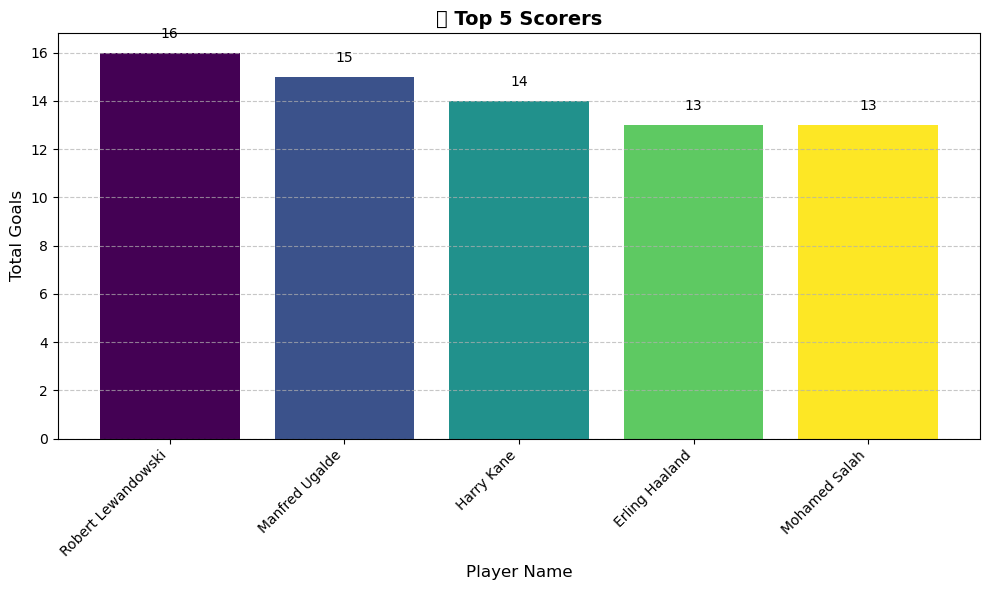

In [23]:
import matplotlib.pyplot as plt
from pymongo import MongoClient
import numpy as np

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["sportDB"]
players_collection = db["players"]

# Aggregation pipeline to find the top 5 scorers
pipeline = [
    {
        "$group": {
            "_id": "$_id",  # Group by player ID
            "total_goals": {"$sum": "$goals"},  # Sum up the goals
            "name": {"$first": "$name"},  # Include the player's name
        }
    },
    {"$sort": {"total_goals": -1}},  # Sort by total goals in descending order
    {"$limit": 5},  # Limit to top 5 players
]

# Execute the aggregation pipeline
top_scorers = list(players_collection.aggregate(pipeline))

# Check if there are any players
if not top_scorers:
    print("🚨 No players found.")
else:
    print("🏆 Top 5 Scorers:")
    for idx, scorer in enumerate(top_scorers, start=1):
        print(f"{idx}. 🥇 Name: {scorer['name']}, Goals: {scorer['total_goals']}")

    # Data for plotting
    player_names = [player["name"] for player in top_scorers]
    total_goals = [player["total_goals"] for player in top_scorers]

    # Create a bar chart for the top scorers
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size for better readability
    colors = plt.cm.viridis(
        np.linspace(0, 1, len(player_names))
    )  # Generate unique colors for each bar

    bars = ax.bar(player_names, total_goals, color=colors)

    # Add goal numbers above the bars
    for bar, goals in zip(bars, total_goals):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,
            str(goals),
            ha="center",
            va="bottom",
            fontsize=10,
            color="black",
        )

    ax.set_xlabel("Player Name", fontsize=12)
    ax.set_ylabel("Total Goals", fontsize=12)
    ax.set_title("🏆 Top 5 Scorers", fontsize=14, weight="bold")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha="right", fontsize=10)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

## b. Team Performance Over Time: Calculate Each Team's Performance Trend in League EPL 2024

#### <> Win - 3 points ............ <> Draw - 1 point ............ <> Loss - 0 point


In [24]:
import datetime
from pymongo import MongoClient, ASCENDING

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["sportDB"]
leagues_collection = db["leagues"]
matches_collection = db["matches"]


def get_league_id(league_title):
    """
    Retrieves the league_id for a given league title.

    :param league_title: The title/name of the league (e.g., 'EPL').
    :return: The league_id if found, else None.
    """
    league = leagues_collection.find_one({"name": league_title})
    if league:
        return league["_id"]
    else:
        print(f"🚨 League titled '{league_title}' not found.")
        return None


def get_team_performance_over_time(league_title="EPL"):
    """
    Aggregates and prints the performance of each team in the specified league over time.

    :param league_title: The title of the league to filter matches (default: 'EPL').
    """
    league_id = get_league_id(league_title)
    if not league_id:
        print("❌ Cannot proceed without a valid league_id.")
        return

    print(f"\n📊 Team Performance Over Time for League: {league_title}")

    pipeline = [
        {"$match": {"league_id": league_id}},
        {
            "$project": {
                "home_team_id": 1,
                "home_team_title": 1,
                "away_team_id": 1,
                "away_team_title": 1,
                "home_team_goals": 1,
                "away_team_goals": 1,
                "datetime": 1,
            }
        },
        {
            "$facet": {
                "home_matches": [
                    {
                        "$project": {
                            "team_id": "$home_team_id",
                            "team_name": "$home_team_title",
                            "goals_scored": "$home_team_goals",
                            "goals_conceded": "$away_team_goals",
                            "result": {
                                "$cond": [
                                    {"$gt": ["$home_team_goals", "$away_team_goals"]},
                                    "Win",
                                    {
                                        "$cond": [
                                            {
                                                "$eq": [
                                                    "$home_team_goals",
                                                    "$away_team_goals",
                                                ]
                                            },
                                            "Draw",
                                            "Loss",
                                        ]
                                    },
                                ]
                            },
                            "datetime": 1,
                        }
                    }
                ],
                "away_matches": [
                    {
                        "$project": {
                            "team_id": "$away_team_id",
                            "team_name": "$away_team_title",
                            "goals_scored": "$away_team_goals",
                            "goals_conceded": "$home_team_goals",
                            "result": {
                                "$cond": [
                                    {"$gt": ["$away_team_goals", "$home_team_goals"]},
                                    "Win",
                                    {
                                        "$cond": [
                                            {
                                                "$eq": [
                                                    "$away_team_goals",
                                                    "$home_team_goals",
                                                ]
                                            },
                                            "Draw",
                                            "Loss",
                                        ]
                                    },
                                ]
                            },
                            "datetime": 1,
                        }
                    }
                ],
            }
        },
        {
            "$project": {
                "all_matches": {"$concatArrays": ["$home_matches", "$away_matches"]}
            }
        },
        {"$unwind": "$all_matches"},
        {"$sort": {"all_matches.datetime": ASCENDING}},
        {
            "$group": {
                "_id": "$all_matches.team_id",
                "team_name": {"$first": "$all_matches.team_name"},
                "matches": {
                    "$push": {
                        "datetime": "$all_matches.datetime",
                        "result": "$all_matches.result",
                        "goals_scored": "$all_matches.goals_scored",
                        "goals_conceded": "$all_matches.goals_conceded",
                    }
                },
            }
        },
        {"$project": {"_id": 0, "team_id": "$_id", "team_name": 1, "matches": 1}},
    ]

    try:
        team_performance = list(matches_collection.aggregate(pipeline))
    except Exception as e:
        print(f"❌ An error occurred during aggregation: {e}")
        return

    if not team_performance:
        print("⚠️ No team performance data found for the specified league.")
        return

    for team in team_performance:
        team_name = team.get("team_name", "Unknown Team")
        print(f"\n⚽ Team: {team_name}")
        cumulative_points = 0
        cumulative_goals_scored = 0
        cumulative_goals_conceded = 0
        for match in team["matches"]:
            result = match.get("result", "Unknown")
            goals_scored = match.get("goals_scored", 0)
            goals_conceded = match.get("goals_conceded", 0)

            if result == "Win":
                cumulative_points += 3
            elif result == "Draw":
                cumulative_points += 1

            cumulative_goals_scored += goals_scored
            cumulative_goals_conceded += goals_conceded

            match_datetime = match.get("datetime")
            if isinstance(match_datetime, datetime.datetime):
                match_date_str = match_datetime.strftime("%Y-%m-%d %H:%M:%S")
            else:
                match_date_str = str(match_datetime)

            print(
                f"  📅 Match on {match_date_str}: {result} | "
                f"Points: {cumulative_points}, Goals Scored: {cumulative_goals_scored}, "
                f"Goals Conceded: {cumulative_goals_conceded}"
            )

    # Optionally, return team_performance for further use
    return team_performance


# Execute the function for EPL
team_performance = get_team_performance_over_time("EPL")


📊 Team Performance Over Time for League: EPL

⚽ Team: Ipswich
  📅 Match on 2024-08-17 11:30:00: Loss | Points: 0, Goals Scored: 0, Goals Conceded: 2
  📅 Match on 2024-08-24 14:00:00: Loss | Points: 0, Goals Scored: 1, Goals Conceded: 6
  📅 Match on 2024-08-31 14:00:00: Draw | Points: 1, Goals Scored: 2, Goals Conceded: 7
  📅 Match on 2024-09-14 14:00:00: Draw | Points: 2, Goals Scored: 2, Goals Conceded: 7
  📅 Match on 2024-09-21 14:00:00: Draw | Points: 3, Goals Scored: 3, Goals Conceded: 8
  📅 Match on 2024-09-29 13:00:00: Draw | Points: 4, Goals Scored: 5, Goals Conceded: 10
  📅 Match on 2024-10-05 14:00:00: Loss | Points: 4, Goals Scored: 6, Goals Conceded: 14
  📅 Match on 2024-10-19 14:00:00: Loss | Points: 4, Goals Scored: 6, Goals Conceded: 16
  📅 Match on 2024-10-26 14:00:00: Loss | Points: 4, Goals Scored: 9, Goals Conceded: 20
  📅 Match on 2024-11-02 15:00:00: Draw | Points: 5, Goals Scored: 10, Goals Conceded: 21
  📅 Match on 2024-11-10 14:00:00: Win | Points: 8, Goals Scor

### (Optional) Visualisation


/var/folders/bq/02b6z17j54jfyf3x41wyw48w0000gn/T/ipykernel_16036/3170238262.py:86: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()  # Adjust layout to prevent clipping of labels
/Users/louistran/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


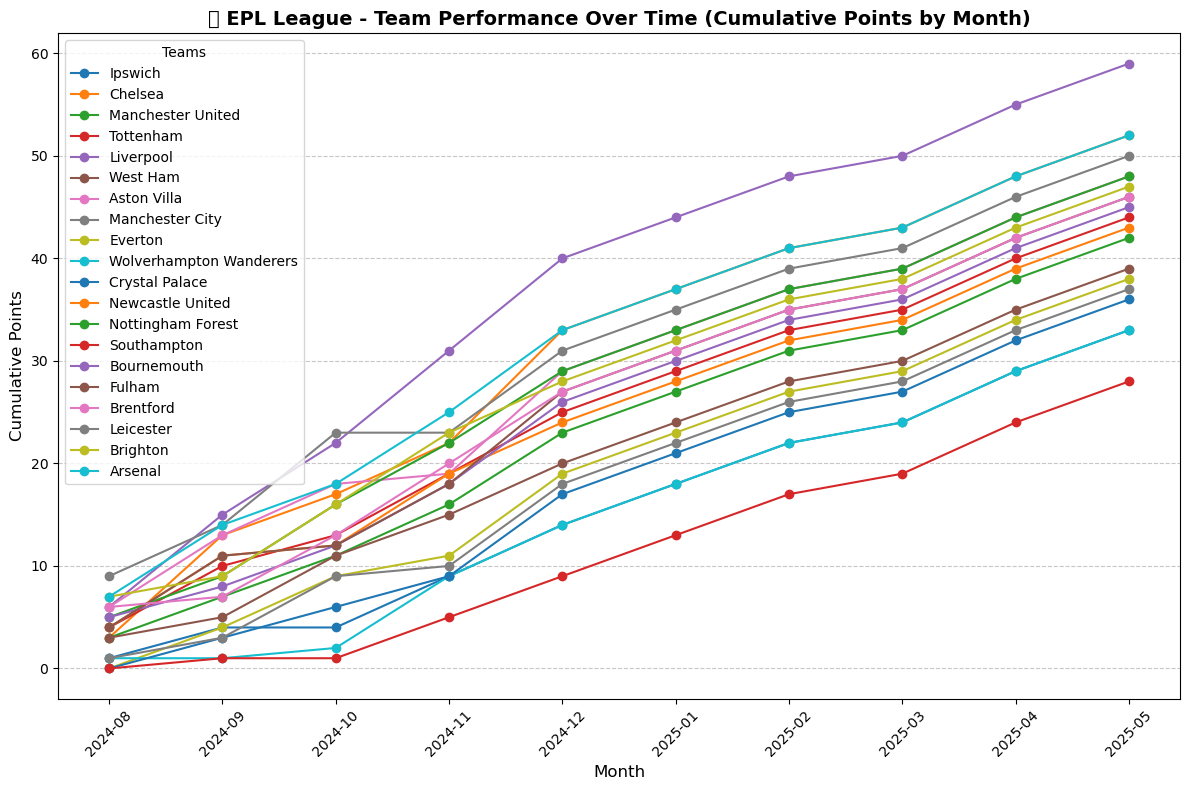

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


def aggregate_points_by_month(team_performance):
    """
    Aggregates cumulative points for each team by month.

    :param team_performance: List of dictionaries containing team performance data.
    :return: Dictionary with team names as keys and DataFrames as values.
    """
    team_monthly_performance = {}

    for team in team_performance:
        team_name = team.get("team_name", "Unknown Team")
        matches = team.get("matches", [])

        if not matches:
            print(f"⚠️ No matches found for team: {team_name}")
            continue

        # Create a DataFrame for the team's matches
        df = pd.DataFrame(matches)

        # Ensure 'datetime' is a datetime object
        df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

        # Drop rows with invalid datetime values
        df = df.dropna(subset=["datetime"])

        # Extract month and year for grouping
        df["month"] = df["datetime"].dt.to_period("M")

        # Calculate points per match
        df["points"] = df["result"].apply(
            lambda x: 3 if x == "Win" else (1 if x == "Draw" else 0)
        )

        # Group by month and sum the points
        monthly_points = df.groupby("month")["points"].sum().reset_index()

        # Sort by month
        monthly_points = monthly_points.sort_values("month")

        # Calculate cumulative points
        monthly_points["cumulative_points"] = monthly_points["points"].cumsum()

        # Convert 'month' back to string for plotting
        monthly_points["month"] = monthly_points["month"].astype(str)

        # Store in the dictionary
        team_monthly_performance[team_name] = monthly_points

    return team_monthly_performance


def visualize_team_performance_monthly(team_monthly_performance):
    """
    Visualizes the cumulative points of each team over time, grouped by month.

    :param team_monthly_performance: Dictionary with team names as keys and DataFrames as values.
    """
    if not team_monthly_performance:
        print("❌ No team performance data to visualize.")
        return

    plt.figure(figsize=(12, 8))  # Adjusted figure size for better readability

    for team_name, df in team_monthly_performance.items():
        months = df["month"]
        cumulative_points = df["cumulative_points"]

        plt.plot(months, cumulative_points, marker="o", label=team_name)

    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Cumulative Points", fontsize=12)
    plt.title(
        "📊 EPL League - Team Performance Over Time (Cumulative Points by Month)",
        fontsize=14,
        weight="bold",
    )
    plt.legend(title="Teams", loc="upper left", fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels for better readability
    plt.yticks(fontsize=10)
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()


# Aggregate points by month
team_monthly_performance = aggregate_points_by_month(team_performance)

# Visualize the performance
visualize_team_performance_monthly(team_monthly_performance)

## c. Real-Time Match Summary

### Summarise the result for a match include:

. Team Name

. Goal Result

. Date of the match

. Top score by player along with the number of goals


In [26]:
def get_live_match_summary(match_id):
    """
    Retrieves and displays a live match summary, including current score, top scorer, and the number of their goals.

    Parameters:
        match_id (str): The unique identifier for the match.
    """
    # Retrieve the match document
    match = matches_collection.find_one({"_id": match_id})

    if not match:
        print("❌ Match not found.")
        return

    print(f"\n📊 Live Match Summary for Match ID: {match_id}")
    print(f"📅 Match Date: {match.get('datetime', 'Unknown')}\n")

    # Extract team and score details from the match document
    home_team_title = match.get("home_team_title", "N/A")
    home_team_goals = match.get("home_team_goals", 0)

    away_team_title = match.get("away_team_title", "N/A")
    away_team_goals = match.get("away_team_goals", 0)

    # Aggregation pipeline to identify the top scorer and their goal minutes
    pipeline_top_scorer = [
        {
            "$match": {
                "match_id": match_id,
                "result": "Goal",  # Ensure only goals are counted
            }
        },
        {
            "$group": {
                "_id": "$player_id",
                "total_goals": {"$sum": 1},
                "goal_minutes": {"$push": "$minute"},
            }
        },
        {"$sort": {"total_goals": -1}},  # Sort by total goals in descending order
        {"$limit": 1},  # Get the top scorer
        {
            "$lookup": {
                "from": "players",
                "localField": "_id",
                "foreignField": "_id",
                "as": "player_details",
            }
        },
        {"$unwind": "$player_details"},  # Extract player details
        {
            "$project": {
                "_id": 0,
                "player_id": "$_id",
                "player_name": "$player_details.name",
                "total_goals": 1,
                "goal_minutes": 1,
            }
        },
    ]

    # Execute the aggregation pipeline
    top_scorer = list(shots_collection.aggregate(pipeline_top_scorer))

    # Format the top scorer information
    if top_scorer:
        top_scorer = top_scorer[0]
        goal_minutes = ", ".join(map(str, top_scorer["goal_minutes"]))
        top_scorer_info = (
            f"{top_scorer['player_name']} ({top_scorer['total_goals']} goal(s) "
            f"at minutes: {goal_minutes})"
        )
    else:
        top_scorer_info = "No goals scored yet."

    # Display the match summary
    print(
        f"⚽ Match: {home_team_title} {home_team_goals} - {away_team_goals} {away_team_title}"
    )
    print(f"🌟 Top Scorer: {top_scorer_info}\n")


# Example Usage
# Replace 'M001' with the actual match ID you want to query
get_live_match_summary(match_data[0]["_id"])


📊 Live Match Summary for Match ID: 26602
📅 Match Date: 2024-08-16 19:00:00

⚽ Match: Manchester United 1 - 0 Fulham
🌟 Top Scorer: Joshua Zirkzee (1 goal(s) at minutes: 86)



## 2. Nested Array

### Retrieves the most recent goals scored by each team (home and away) in a match.


In [27]:
def get_most_recent_goals_per_team_with_filter(match_id):
    """
    Retrieves the most recent goals scored by each team (home and away) in a match,
    using $filter and $arrayElemAt for precise array operations.

    Parameters:
        match_id (str): The unique identifier for the match.
    """
    print(f"\n📊 Most Recent Goals for Each Team in Match ID: {match_id}")

    pipeline = [
        {
            "$match": {
                "match_id": match_id,
                "result": "Goal",
                "player_id": {"$ne": None},
            }
        },
        {
            "$lookup": {
                "from": "players",
                "localField": "player_id",
                "foreignField": "_id",
                "as": "player_details",
            }
        },
        {"$unwind": "$player_details"},  # Flatten player details
        {
            "$group": {
                "_id": "$h_a",  # Group by home ('h') or away ('a') team
                "goals": {
                    "$push": {
                        "minute": "$minute",
                        "player_id": "$player_id",
                        "player_name": "$player_details.name",
                        "team_name": {
                            "$cond": {
                                "if": {"$eq": ["$h_a", "h"]},
                                "then": "$h_team",
                                "else": "$a_team",
                            }
                        },
                    }
                },
            }
        },
        {
            "$project": {
                "_id": 0,
                "team_name": {"$arrayElemAt": ["$goals.team_name", 0]},
                "most_recent_goal": {
                    "$arrayElemAt": [
                        {
                            "$filter": {
                                "input": "$goals",
                                "as": "goal",
                                "cond": {
                                    "$eq": ["$$goal.minute", {"$max": "$goals.minute"}]
                                },
                            }
                        },
                        0,
                    ]
                },
            }
        },
    ]

    try:
        # Execute the aggregation pipeline
        recent_goals = list(shots_collection.aggregate(pipeline))

        if not recent_goals:
            print("⚠️ No goals found for this match.")
            return

        # Display results
        for goal in recent_goals:
            team_name = goal.get("team_name", "Unknown Team")
            most_recent_goal = goal.get("most_recent_goal")

            if most_recent_goal:
                player_name = most_recent_goal.get("player_name", "Unknown Player")
                goal_minute = most_recent_goal.get("minute", "Unknown Minute")
                print(f"⚽ Team: {team_name}")
                print(f"  🏃 Most Recent Goal by {player_name} at minute {goal_minute}")
            else:
                print(f"⚽ Team: {team_name}")
                print("  ❌ No goals scored by this team.")

    except Exception as e:
        print(f"❌ An error occurred while retrieving recent goals: {e}")


# Example Usage
get_most_recent_goals_per_team_with_filter(match_data[6]["_id"])


📊 Most Recent Goals for Each Team in Match ID: 26608
⚽ Team: West Ham
  🏃 Most Recent Goal by Lucas Paquetá at minute 36
⚽ Team: Aston Villa
  🏃 Most Recent Goal by Jhon Durán at minute 78


# Part 4: Real-Time Operations


### generate live commentary for a specific match based on the shots data and simulate real-time updates.


In [28]:
import time
from pymongo import MongoClient
from colorama import Fore, Style, init

# Initialize colorama for colorized console output
init(autoreset=True)

# MongoDB connection
client = MongoClient("mongodb://localhost:27017/")
db = client["sportDB"]

# Collections
shots_collection = db["shots"]
matches_collection = db["matches"]
live_commentary_collection = db["liveCommentary"]


# Function to generate live commentary
def generate_live_commentary(match_id):
    """Generates live commentary based on the Shots collection for a specific match."""
    # Get match details
    match = matches_collection.find_one({"_id": match_id})
    if not match:
        print(Fore.RED + f"❌ Match with ID {match_id} not found.")
        return

    home_team_title = match["home_team_title"]
    away_team_title = match["away_team_title"]
    home_team_goals = 0
    away_team_goals = 0

    # Fetch shots for the match, sorted by time
    shots = list(shots_collection.find({"match_id": match_id}).sort("minute", 1))

    print(
        Fore.CYAN
        + f"\n🎙️ Starting live commentary for the match between {home_team_title} and {away_team_title}."
    )
    print(Fore.CYAN + "-" * 60)

    # Generate commentary for each shot
    for shot in shots:
        event = None
        details = None
        team_name = home_team_title if shot["h_a"] == "h" else away_team_title
        if shot["result"] == "Goal":
            player_name = shot["player"]
            assisted_by = (
                f", assisted by {shot['player_assisted']}"
                if shot["player_assisted"]
                else ""
            )
            team_scored = "home team" if shot["h_a"] == "h" else "away team"

            # Update the score
            if shot["h_a"] == "h":
                home_team_goals += 1
            else:
                away_team_goals += 1

            # Generate goal commentary
            event = "Goal"
            details = (
                f"⚽ GOAL! {player_name} scores for the {team_scored} ({team_name}){assisted_by}. "
                f"The score is now {home_team_goals}-{away_team_goals}."
            )
        elif shot["result"] == "SavedShot":
            player_name = shot["player"]
            event = "Save"
            details = (
                f"🛡️ Saved shot by {player_name} from {team_name}. Great effort, but no goal! "
                f"Still {home_team_goals}-{away_team_goals}."
            )
        elif shot["result"] == "MissedShots":
            player_name = shot["player"]
            event = "Missed Shot"
            details = (
                f"❌ Missed chance by {player_name} from {team_name}. The shot goes wide! "
                f"Still {home_team_goals}-{away_team_goals}."
            )

        # Add the commentary to the LiveCommentary collection
        if event and details:
            commentary_doc = {
                "match_id": match_id,
                "timestamp": time.time(),
                "minute": shot["minute"],
                "event": event,  # Event type (Goal, Save, Missed Shot)
                "details": details,  # Detailed commentary
            }
            live_commentary_collection.insert_one(commentary_doc)

            # Print the commentary
            print(
                Fore.CYAN
                + f"🕒 Minute {shot['minute']}' - "
                + Style.RESET_ALL
                + details
            )
            print(Fore.CYAN + "-" * 60)

            # Simulate real-time updates
            time.sleep(2)  # Sleep for 2 seconds to simulate real-time updates

    # Final commentary about the match result
    final_event = "Match End"
    final_details = f"{Fore.BLUE}🏁 The match has ended! Final score: {home_team_title} {home_team_goals} - {away_team_goals} {away_team_title}."
    final_doc = {
        "match_id": match_id,
        "timestamp": time.time(),
        "event": final_event,
        "details": final_details,
    }
    live_commentary_collection.insert_one(final_doc)
    print(Fore.CYAN + "-" * 60)
    print(final_details)


# Start the live commentary simulation for a specific match
# Replace `match_data[6]["_id"]` with your desired match ID
generate_live_commentary(match_data[3]["_id"])


🎙️ Starting live commentary for the match between Everton and Brighton.
------------------------------------------------------------
🕒 Minute 3' - 🛡️ Saved shot by Jack Harrison from Everton. Great effort, but no goal! Still 0-0.
------------------------------------------------------------
🕒 Minute 11' - ❌ Missed chance by Jack Harrison from Everton. The shot goes wide! Still 0-0.
------------------------------------------------------------
🕒 Minute 13' - ❌ Missed chance by James Tarkowski from Everton. The shot goes wide! Still 0-0.
------------------------------------------------------------
🕒 Minute 15' - ❌ Missed chance by Lewis Dunk from Brighton. The shot goes wide! Still 0-0.
------------------------------------------------------------
🕒 Minute 19' - ❌ Missed chance by Tim Iroegbunam from Everton. The shot goes wide! Still 0-0.
------------------------------------------------------------
🕒 Minute 25' - ⚽ GOAL! Kaoru Mitoma scores for the away team (Brighton), assisted by Yankub